a =  0.1837692826001615 b =  0.25584203960134855


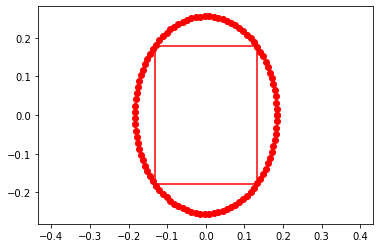

In [2]:
# rectangle de dimension w et h
import matplotlib.pyplot as plt
import numpy as np

def rectangle(w, h, ax):
    # rectangle of width w and height h centerd at (0, 0)
    ax.plot([-h, -h, h, h, -h],[-w, w, w, -w, -w],  'r')

# compute ellipse of focal w and parameter h

def ellipse(w, h, ax):

    L1 = h
    L2 = np.sqrt(h**2 + 4*w**2)
    a = (L1 + L2)/2
    b = np.sqrt(h**2/ (1-w**2/a**2))

    if a > b:
        a, b = b, a

    t = np.linspace(0, 2*np.pi, 100)
    x = a*np.cos(t)
    y = b*np.sin(t)
    ax.plot(x, y, 'ro')
    print('a = ', a, 'b = ', b)

fig, ax = plt.subplots()
rectangle(0.178,0.132, ax)
ellipse(0.178,0.132,ax)
plt.axis('equal')
plt.show()


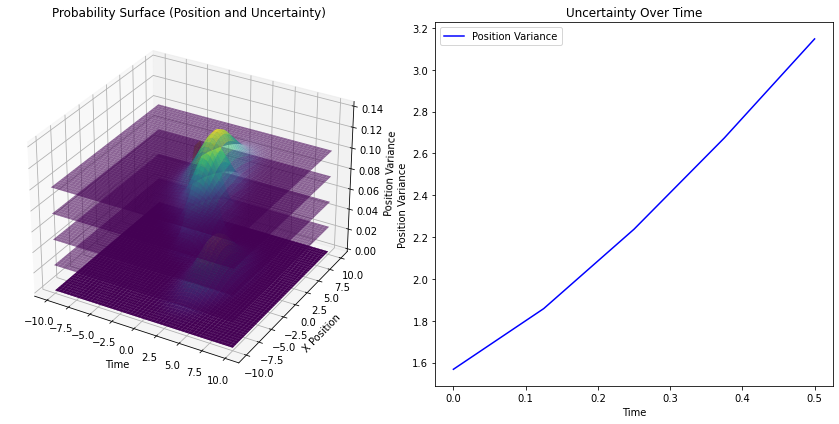

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters for simulation
dt = 0.1  # Time step
time_steps = 5  # Number of steps
time = np.linspace(0, dt * time_steps, time_steps)

# Bicycle model parameters
L = 2.0  # Wheelbase
v = 5.0  # Constant velocity
steering_angle = 0.0 # Constant steering angle (radians)

# Initial state: [x, y, theta, v]
state = np.array([0.0, 0.0, 0.0, v])

# Kalman Filter Parameters
state_dim = 4
P = np.eye(state_dim) * 1.0  # Initial covariance
Q = np.diag([0.1, 0.1, 0.05, 0.1])  # Process noise covariance
F = np.eye(state_dim)  # Placeholder for state transition matrix

# Function to compute the bicycle model state transition
def bicycle_model(state, dt):
    x, y, theta, v = state
    x_new = x + v * np.cos(theta) * dt
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + (v / L) * np.tan(steering_angle) * dt
    return np.array([x_new, y_new, theta_new, v])

# Kalman Filter prediction step
def kalman_predict(state, P, Q, dt):
    global F
    # Update F matrix for the linearized model
    _, _, theta, v = state
    F[0, 2] = -v * np.sin(theta) * dt  # df/dtheta
    F[0, 3] = np.cos(theta) * dt       # df/dv
    F[1, 2] = v * np.cos(theta) * dt   # df/dtheta
    F[1, 3] = np.sin(theta) * dt       # df/dv
    F[2, 3] = (1 / L) * np.tan(steering_angle) * dt  # df/dv

    # Predict state
    predicted_state = bicycle_model(state, dt)
    
    # Predict covariance
    P = F @ P @ F.T + Q
    return predicted_state, P

# Simulation loop
positions = []  # Track positions for visualization
covariances = []  # Track covariance over time

for t in time:
    # Kalman predict step
    state, P = kalman_predict(state, P, Q, dt)
    
    # Store position and covariance
    positions.append(state[:2])  # Only x, y for visualization
    covariances.append(P[:2, :2])  # Store position covariance

# Convert to arrays for plotting
positions = np.array(positions)
covariances = np.array(covariances)

# Extract covariance for plotting
position_variance = np.sqrt(covariances[:, 0, 0] + covariances[:, 1, 1])  # Combined x, y uncertainty

# Plotting the results
fig = plt.figure(figsize=(12, 6))

# 3D plot of position probability
ax = fig.add_subplot(121, projection='3d')

# Function to compute 2D Gaussian
def gaussian_2d(x, y, mean, cov):
    inv_cov = np.linalg.inv(cov)
    diff = np.stack([x - mean[0], y - mean[1]], axis=-1)
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=-1)
    normalizer = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
    return normalizer * np.exp(exponent)

# Generate grid for Gaussian visualization
x_range = np.linspace(-10, 10, 50)
y_range = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x_range, y_range)

# Plot Gaussian distributions at each time step
for i, t in enumerate(time):
    mean = positions[i]
    cov = covariances[i]
    
    # Compute Gaussian for the current time step
    Z = gaussian_2d(X, Y, mean, cov)
    
    # Shift Z values slightly to make each surface distinguishable
    ax.plot_surface(X, Y, Z + t * 0.2, cmap='viridis', alpha=0.6)


surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('Probability Surface (Position and Uncertainty)')
ax.set_xlabel('Time')
ax.set_ylabel('X Position')
ax.set_zlabel('Position Variance')

# 2D plot of uncertainty over time
ax2 = fig.add_subplot(122)
ax2.plot(time, position_variance, label="Position Variance", color="blue")
ax2.set_title("Uncertainty Over Time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Position Variance")
ax2.legend()

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import scipy

def compute_axes(cov, p):
    a=np.sqrt(-2*np.log(1-p))
    A = a * scipy.linalg.sqrtm(cov[:2,:2])
    # print("covariance: ", covariance[:2,:2])
    w, v = scipy.linalg.eigh(A)
    v1 = v[:, 0].real
    v2 = v[:, 1].real
    
    f1 = A @ v1
    f2 = A @ v2
    width = np.linalg.norm(f1)
    height = np.linalg.norm(f2)
    angle = np.arctan2(v1[1], v1[0])
    # width = width - sin(angle) * height
    # height = sin(angle) * width + cos(angle) * height
    return width, height

In [23]:
width1 = 0.178
height1 = 0.132
width2 = 0.178
height2 = 0.132


E = np.zeros((2,2))
E[0,0] = (width1 + width2)**2
E[1,1] = (width1 + width2)**2
R1 = np.eye((2))
R = R1
E = R @ E @ R.T


cov = np.array([[0.01, 0.0], [0.0, 0.01]])
a_x, a_y  = compute_axes(cov, 0.99)


p_i = np.array([0,0])
p_j = np.array([1.2,0])
v_i = np.array([0,0])
v_j = np.array([-0.5,0])


Sigma = np.linalg.inv(E)

dij = np.sqrt((p_i - p_j).T @ Sigma @ (p_i - p_j))
dij_dot = 2 * (v_i - v_j).T @ Sigma @ (p_i - p_j)/dij
print(Sigma, dij, dij_dot)
print((1-dij)/dij_dot if dij_dot < 0 else -1) 

E[0,0] = (width1 + width2)**2  + a_x**2
E[1,1] = (width1 + width2)**2  + a_y**2
Sigma = np.linalg.inv(E)

dij = np.sqrt((p_i - p_j).T @ Sigma @ (p_i - p_j))
dij_dot = 2 * (v_i - v_j).T @ Sigma @ (p_i - p_j)/dij
print(Sigma, dij, dij_dot)
print((1-dij)/dij_dot if dij_dot < 0 else -1) 

[[7.89041788 0.        ]
 [0.         7.89041788]] 3.3707865168539324 -2.808988764044944
0.8439999999999999
[[4.56956098 0.        ]
 [0.         4.56956098]] 2.565183777116592 -2.1376531475971605
0.7321972598201653


(-0.10959863642878868,
 0.10886292504709037,
 -0.0967622791523814,
 0.10032073440120146)

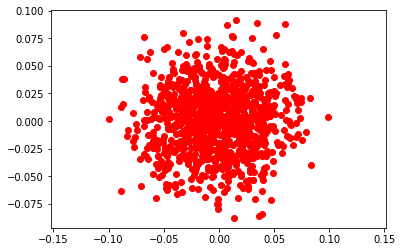

In [24]:
samples = np.random.multivariate_normal([0,0], np.diag([0.001, 0.001]), 1000)
plt.plot(samples[:,0], samples[:,1], 'ro')
plt.axis('equal')